In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 **Background**

This dataset  has  images of  plant seedlings at various stages of  grown.  Each image has a filename that is its unique  id.  The  dataset  comprises  12  plant  species.  The  goal  of  the  project  is  to  create  a  classifier  capable  of  determining  a plant's species from a photo.

The data file names are:
images.npy

Label.csv

In [2]:
# Importing different libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import math 
import cv2 
from glob import glob 
import itertools
# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend
from tensorflow import keras
import seaborn as sns

In [3]:
from google.colab import files
uploaded=files.upload()

Saving images.npy to images.npy
Saving Labels.csv to Labels.csv


In [4]:
#Loading the dataset using pandas and numpy
imag=np.load("images.npy")
labe=pd.read_csv("Labels.csv")

#The dataset has two parts
- Images is the X data
- Label consists the Target data

In [5]:
#Copying the original dataset
label=labe.copy() #Training dataset
image=imag.copy() #testing dataset

In [6]:
#Shape of the label
label.shape

(4750, 1)

In [7]:
#Shape of the Image data
image.shape

(4750, 128, 128, 3)

- Both datasets have 4750 rows.
- the image pixel seize is 128x128
- the images are color images

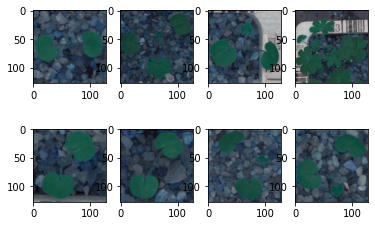

In [8]:
#Showing 8 images from the image dataset
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(image[i])
#This will plot the first 8 images.

In [14]:
#Reading the a sample of datasets
label.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [15]:
#Checking the types of plants
label.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

- 12 types of plants name are labeled in the dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


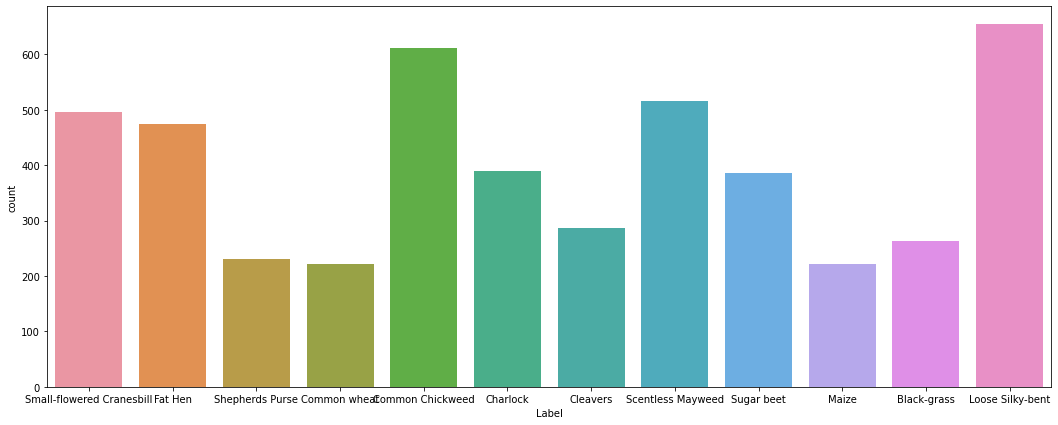

In [18]:
#Types of data are depicted using countplot
plt.figure(figsize=(18,7))
sns.countplot(label["Label"])
plt.show()

- Loose silky bent is the major type of plant 
- Common wheat and maize are the least type of plant

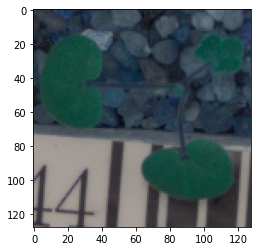

In [64]:
# showing some random image of plant 
plt.imshow(image[12])    
plt.show()

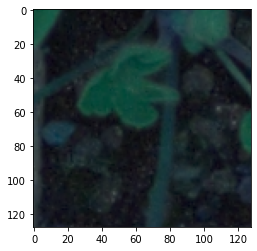

In [65]:
#Showing another image
plt.imshow(image[120])    
plt.show()

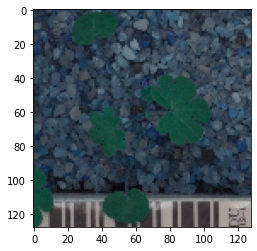

In [66]:
#Showing another image
plt.imshow(image[68])    
plt.show()

### **Preprocessig**

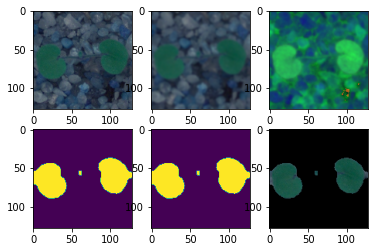

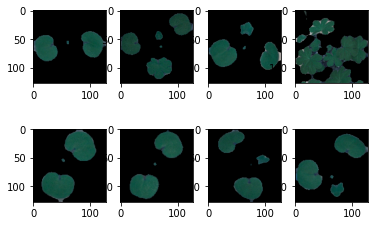

In [10]:
#Guassian Blurring, Masking

new_train = []
sets = []; getEx = True
for i in image:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # original image
        plt.subplot(2,3,2);plt.imshow(blurr) # blurred
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV converted
        plt.subplot(2,3,4);plt.imshow(mask) # masked
        plt.subplot(2,3,5);plt.imshow(boolean) # boolean masked
        plt.subplot(2,3,6);plt.imshow(new) # new processed image
        plt.show()
        getEx = False
new_train = np.asarray(new_train)
# showing the cleaned images after implementation gaussian blurring and masking
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

In [11]:
#Normalizing the input data between 0 and 255
image= image/255.0

In [12]:
# storing the LabelBinarizer function in lb variable
lb = LabelBinarizer()
# applying fit_transform on target variable
label_e = lb.fit_transform(label)

In [13]:
#Converting into Numpy array
image= np.array(image) 
label_e= np.array(label_e)

In [14]:
#Defining X and Y variable before spliting the data
x=image
y=label_e

In [15]:
#splitting the data into test and temporary data sets
X_temp, X_test, y_temp, y_test=train_test_split(x, y, test_size=0.20, random_state=1, stratify=y)

In [16]:
#splittig the dataset into train and validation
X_train, X_val, y_train, y_val=train_test_split(X_temp, y_temp, test_size=0.20, random_state=1, stratify=y_temp)

# **Model Building**

In [17]:
#Fixing the random seed so the output remain same
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

# **Little Description on different conpcepts related with model:**
**Filters**: 256- Number of filters in the first hidden layer.This is also called as Kernel

**Kernel_Size:** The kernel size here refers to the widthxheight of the filter mask. The kernel_size must be an odd integer. Normally we take: (1, 1) , (3, 3) , (5, 5) , (7, 7)

**MaxPool2D:** Max Pooling is a pooling operation that calculates the maximum value for patches of a feature map. the another pooling is average poolin. Here we will use Maxpooling. It is usually used after a convolutional layer.

**Flatten:** Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector. And it is connected to the final classification model, which is called a fully-connected layer.

**Hidden Layers:** In the Neural network model hidden layers are used. In this project we have used 3 and 5 hidden layers. 

**Dropout**: In this project, I have used dropout layer, which is used reduce ovrfitting.

**Optimization:** As optimizer, here mainly adam optimizer is used

**Activation function:** As activation function, the relu is used in iput and hidded layer. In the output Softmax is used as it is classification problem.

In [18]:
# Defining Artificial Neural Network Model
def create_model(): 
        # we will be adding the layers sequentially
        model_ann = keras.Sequential([
            # flattening the 3-d output of the conv layer and making it ready for creating dense connections
            keras.layers.Flatten(input_shape=(128,128,3)), 
            # first hidden layer with 500 neurons, kernel_initializer as 'he_uniform" and relu activation function
            keras.layers.Dense(500,kernel_initializer='he_uniform', activation=tf.nn.relu), 
            # second hidden layer with 700 neurons, kernel_initializer as 'he_uniform" and relu activation function
            keras.layers.Dense(700,kernel_initializer='he_uniform', activation=tf.nn.relu),
            # output layer with 12 neuron and softmax as activation function will give the probability of each class   
            keras.layers.Dense(12, kernel_initializer='random_uniform',activation=tf.nn.softmax)
        ])

        # Compiling the model using adam optimizer, categorical_crossentrophy as loss and accuracy as metric
        model_ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model_ann

In [19]:
#Creating the model using defined model and and showing the summary
model_ann=create_model()
model_ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 500)               24576500  
                                                                 
 dense_1 (Dense)             (None, 700)               350700    
                                                                 
 dense_2 (Dense)             (None, 12)                8412      
                                                                 
Total params: 24,935,612
Trainable params: 24,935,612
Non-trainable params: 0
_________________________________________________________________


- Total number of parameters 24,935,612

In [20]:
# Fitting the ANN to the Training data , batch size used 200 and 10 epochs
history = model_ann.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size = 200, epochs = 10, verbose = 1)

Epoch 1/10
16/16 [==============================] - 3s 40ms/step - loss: 15.7580 - accuracy: 0.0967 - val_loss: 5.0558 - val_accuracy: 0.0816
Epoch 2/10
16/16 [==============================] - 0s 22ms/step - loss: 4.1328 - accuracy: 0.1010 - val_loss: 2.7632 - val_accuracy: 0.0605
Epoch 3/10
16/16 [==============================] - 0s 23ms/step - loss: 2.5250 - accuracy: 0.1507 - val_loss: 2.3814 - val_accuracy: 0.1789
Epoch 4/10
16/16 [==============================] - 0s 21ms/step - loss: 2.3260 - accuracy: 0.1954 - val_loss: 2.2817 - val_accuracy: 0.1882
Epoch 5/10
16/16 [==============================] - 0s 22ms/step - loss: 2.1962 - accuracy: 0.2497 - val_loss: 2.2339 - val_accuracy: 0.2553
Epoch 6/10
16/16 [==============================] - 0s 22ms/step - loss: 2.1235 - accuracy: 0.2490 - val_loss: 2.1181 - val_accuracy: 0.3013
Epoch 7/10
16/16 [==============================] - 0s 22ms/step - loss: 2.0270 - accuracy: 0.3128 - val_loss: 2.0351 - val_accuracy: 0.2868
Epoch 8/10
1

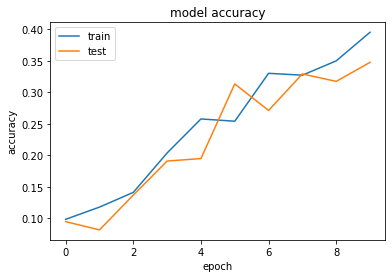

In [ ]:
#plotting the model accuracy with the rise in epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- Genral we see the accuracy has increase with the increase in epoch

In [34]:
results = model_ann.evaluate(X_val, y_val)
print('Val_acc using simple NN adam : ', results[1])

24/24 [==============================] - 0s 9ms/step - loss: 1.8710 - accuracy: 0.3382
Val_acc using simple NN adam :  0.33815789222717285


- 34 percent accuracy and loss is 1.870 using the ANN model with ADAM and the model is not highly suffering from overfitting

## **ANN model with SGD optimizer**

In [35]:
# Defining Artificial Neural Network Model
def create_model_sgd(): 
        # we will be adding the layers sequentially
        model_ann = keras.Sequential([
            # flattening the 3-d output of the conv layer and making it ready for creating dense connections
            keras.layers.Flatten(input_shape=(128,128,3)), 
            # first hidden layer with 500 neurons, kernel_initializer as 'he_uniform" and relu activation function
            keras.layers.Dense(500,kernel_initializer='he_uniform', activation=tf.nn.relu), 
            # second hidden layer with 700 neurons, kernel_initializer as 'he_uniform" and relu activation function
            keras.layers.Dense(700,kernel_initializer='he_uniform', activation=tf.nn.relu),
            # output layer with 12 neuron and softmax as activation function will give the probability of each class   
            keras.layers.Dense(12, kernel_initializer='random_uniform',activation=tf.nn.softmax)
        ])

        # Compiling the model using adam optimizer, categorical_crossentrophy as loss and accuracy as metric
        model_ann_sgd.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
        return model_ann_sgd

In [36]:
#Creating the model using defined model and and showing the summary
model_ann_sgd=create_model()
model_ann_sgd.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_3 (Dense)             (None, 500)               24576500  
                                                                 
 dense_4 (Dense)             (None, 700)               350700    
                                                                 
 dense_5 (Dense)             (None, 12)                8412      
                                                                 
Total params: 24,935,612
Trainable params: 24,935,612
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Fitting the ANN to the Training data , batch size used 200 and 10 epochs
history = model_ann_sgd.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size = 200, epochs = 10, verbose = 1)

Epoch 1/10
16/16 [==============================] - 3s 128ms/step - loss: 19.1852 - accuracy: 0.0974 - val_loss: 5.9484 - val_accuracy: 0.1000
Epoch 2/10
16/16 [==============================] - 1s 68ms/step - loss: 3.9712 - accuracy: 0.1072 - val_loss: 2.6773 - val_accuracy: 0.1132
Epoch 3/10
16/16 [==============================] - 1s 59ms/step - loss: 2.4998 - accuracy: 0.1543 - val_loss: 2.4227 - val_accuracy: 0.1184
Epoch 4/10
16/16 [==============================] - 1s 59ms/step - loss: 2.3481 - accuracy: 0.1684 - val_loss: 2.2929 - val_accuracy: 0.2224
Epoch 5/10
16/16 [==============================] - 1s 61ms/step - loss: 2.2253 - accuracy: 0.2352 - val_loss: 2.2217 - val_accuracy: 0.2329
Epoch 6/10
16/16 [==============================] - 1s 56ms/step - loss: 2.1620 - accuracy: 0.2382 - val_loss: 2.1772 - val_accuracy: 0.1921
Epoch 7/10
16/16 [==============================] - 1s 58ms/step - loss: 2.0674 - accuracy: 0.2760 - val_loss: 2.0868 - val_accuracy: 0.2632
Epoch 8/10


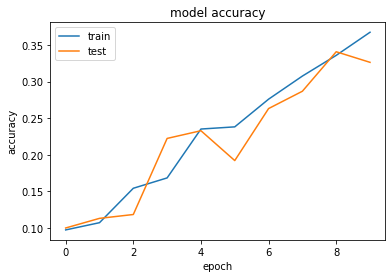

In [38]:
#plotting the model accuracy with the rise in epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
results = model_ann_sgd.evaluate(X_val, y_val)
print('Val_acc using simple NN SGD : ', results[1])

24/24 [==============================] - 0s 10ms/step - loss: 1.9341 - accuracy: 0.3263
Val_acc using simple NN SGD :  0.3263157904148102


- Model with SGD Opitmizer has also given same kind of accuracy and in terms of overfitting, the gap between accuracy and val_accuracy decreased

## **Building CNN Model**

In [21]:
#Fixing random seed
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [22]:
# initialized a sequential model
model_cnn = Sequential()

# adding first conv layer with 256 filters and kernel size 5x5 , with ReLU activation and padding 'same' provides the output size same as the input size
#input_shape denotes input image dimension of images
model_cnn.add(Conv2D(filters = 256, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))  # Shape of the image given to the model
# adding max pooling to reduce the size of output of first conv layer
model_cnn.add(MaxPooling2D(pool_size=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn.add(Dropout(0.25))

#  adding second conv layer with 128 filters and with kernel size 3x3 and ReLu activation function
model_cnn.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# adding max pooling havinf pool_size and strides with (2,2) to reduce the size of output of second conv layer
model_cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn.add(Dropout(0.25))

#  adding third conv layer with 128 filters and with kernel size 3x3 and ReLu activation function
model_cnn.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# adding max pooling havinf pool_size and strides with (2,2) to reduce the size of output of third conv layer
model_cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn.add(Dropout(0.25))

# flattening the 3-d output of the conv layer after max pooling to make it ready for creating dense connections
model_cnn.add(Flatten())
# adding a fully connected dense layer with 256 neurons 
model_cnn.add(Dense(256, activation = "relu"))
model_cnn.add(Dropout(0.5))

# adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem.
model_cnn.add(Dense(12, activation = "softmax"))

In [23]:
# printing the model summary
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     19456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)      

In [24]:
# compiling the model using adam optimizer
model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [25]:
# Fitting the CNN to the Training data , batch size used 200 and 5 epochs
history = model_cnn.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size = 200, epochs = 10, verbose = 1)

Epoch 1/10
16/16 [==============================] - 16s 366ms/step - loss: 2.5661 - accuracy: 0.1276 - val_loss: 2.4290 - val_accuracy: 0.1395
Epoch 2/10
16/16 [==============================] - 5s 298ms/step - loss: 2.4238 - accuracy: 0.1368 - val_loss: 2.4063 - val_accuracy: 0.2382
Epoch 3/10
16/16 [==============================] - 5s 297ms/step - loss: 2.3298 - accuracy: 0.2000 - val_loss: 2.1282 - val_accuracy: 0.2921
Epoch 4/10
16/16 [==============================] - 5s 298ms/step - loss: 2.0225 - accuracy: 0.3247 - val_loss: 1.9382 - val_accuracy: 0.3711
Epoch 5/10
16/16 [==============================] - 5s 299ms/step - loss: 1.8474 - accuracy: 0.3704 - val_loss: 1.6879 - val_accuracy: 0.4342
Epoch 6/10
16/16 [==============================] - 5s 297ms/step - loss: 1.7002 - accuracy: 0.4158 - val_loss: 1.6382 - val_accuracy: 0.4329
Epoch 7/10
16/16 [==============================] - 5s 297ms/step - loss: 1.6283 - accuracy: 0.4411 - val_loss: 1.4648 - val_accuracy: 0.5237
Epoch

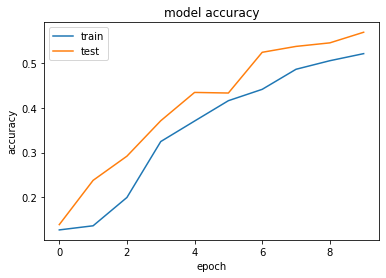

In [26]:
#plotting the model accuracy with the rise in epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Using CNN shows better improvement in accury with the higher number of epoch in comparison of the other two models using ANN

In [28]:
results = model_cnn.evaluate(X_val, y_val)
print('Val_acc using CNN with optimizer ADAM : ', results[1])

24/24 [==============================] - 1s 24ms/step - loss: 1.2938 - accuracy: 0.5684
Val_acc using CNN with optimizer ADAM :  0.5684210658073425


Using CNN model, we observe more accuracy 57 percent. however it is still not satisfactory. We wil try with other hyperparameters tuning, whether it works and overfitting is in control

## **Adding Learning rate with CNN using Adam**

In [31]:
# Adding learning rate in cnn model
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model_cnn.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model_cnn.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size = 200, epochs = 20, verbose = 1)

Epoch 1/20
16/16 [==============================] - 6s 317ms/step - loss: 1.2560 - accuracy: 0.5783 - val_loss: 1.1819 - val_accuracy: 0.6145
Epoch 2/20
16/16 [==============================] - 5s 300ms/step - loss: 1.2000 - accuracy: 0.6003 - val_loss: 1.1501 - val_accuracy: 0.6105
Epoch 3/20
16/16 [==============================] - 5s 296ms/step - loss: 1.1634 - accuracy: 0.6000 - val_loss: 1.1493 - val_accuracy: 0.6079
Epoch 4/20
16/16 [==============================] - 5s 298ms/step - loss: 1.1295 - accuracy: 0.6105 - val_loss: 1.1378 - val_accuracy: 0.6171
Epoch 5/20
16/16 [==============================] - 5s 300ms/step - loss: 1.0899 - accuracy: 0.6362 - val_loss: 1.1307 - val_accuracy: 0.6145
Epoch 6/20
16/16 [==============================] - 5s 297ms/step - loss: 1.0657 - accuracy: 0.6329 - val_loss: 1.1141 - val_accuracy: 0.6237
Epoch 7/20
16/16 [==============================] - 5s 297ms/step - loss: 1.0295 - accuracy: 0.6553 - val_loss: 1.0971 - val_accuracy: 0.6211
Epoch 

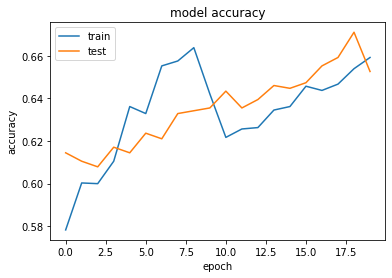

In [32]:
#plotting the model accuracy with the rise in epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- From the above graph, we see the performence is best with the 1o th epoch, so adding more epoch has not helped, optimum number is 10
- However adding learning rate has helped to increase the performence
- the accuracy and val_accuracy is almost same

In [33]:
results = model_cnn.evaluate(X_val, y_val)
print('Val_acc using CNN with optimizer ADAM : ', results[1])

24/24 [==============================] - 0s 19ms/step - loss: 1.0208 - accuracy: 0.6526
Val_acc using CNN with optimizer ADAM :  0.6526315808296204


- After adding learning accuracu has increased to 65 percent with loss 1.0208adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model_cnn.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model_cnn.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size = 200, epochs = 20, verbose = 1)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint

### **# Adding more layers in the model and adding early stopping **

In [39]:
# initialized a sequential model
model_cnn_m = Sequential()

In [40]:
# adding first conv layer with 256 filters and kernel size 5x5 , with ReLU activation and padding 'same' provides the output size same as the input size
#input_shape denotes input image dimension of images
model_cnn_m.add(Conv2D(filters = 256, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))  # Shape of the image given to the model
# adding max pooling to reduce the size of output of first conv layer
model_cnn_m.add(MaxPooling2D(pool_size=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn_m.add(Dropout(0.25))

#  adding second conv layer with 128 filters and with kernel size 3x3 and ReLu activation function
model_cnn_m.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# adding max pooling havinf pool_size and strides with (2,2) to reduce the size of output of second conv layer
model_cnn_m.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn_m.add(Dropout(0.25))

#  adding third conv layer with 128 filters and with kernel size 3x3 and ReLu activation function
model_cnn_m.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# adding max pooling havinf pool_size and strides with (2,2) to reduce the size of output of third conv layer
model_cnn_m.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn_m.add(Dropout(0.25))

#  adding fourth conv layer with 128 filters and with kernel size 3x3 and ReLu activation function
model_cnn_m.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# adding max pooling havinf pool_size and strides with (2,2) to reduce the size of output of third conv layer
model_cnn_m.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn_m.add(Dropout(0.25))

#  adding fifth conv layer with 128 filters and with kernel size 3x3 and ReLu activation function
model_cnn_m.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# adding max pooling havinf pool_size and strides with (2,2) to reduce the size of output of third conv layer
model_cnn_m.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn_m.add(Dropout(0.25))

# flattening the 3-d output of the conv layer after max pooling to make it ready for creating dense connections
model_cnn_m.add(Flatten())
# adding a fully connected dense layer with 256 neurons 
model_cnn_m.add(Dense(256, activation = "relu"))
model_cnn_m.add(Dropout(0.5))

# adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem.
model_cnn_m.add(Dense(12, activation = "softmax"))

In [51]:
model_cnn_m.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 256)     19456     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 128)      

- we will here apply 1,284,876 parameters in this model

In [41]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model_cnn_m.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Fitting the model with 30 epochs and validation_split as 20%
history = model_cnn_m.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size = 200, epochs = 20, verbose = 1, callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 2.4642 - accuracy: 0.1224
Epoch 1: val_accuracy improved from -inf to 0.13816, saving model to best_model.h5
16/16 [==============================] - 6s 334ms/step - loss: 2.4642 - accuracy: 0.1224 - val_loss: 2.4539 - val_accuracy: 0.1382
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 2.4378 - accuracy: 0.1306
Epoch 2: val_accuracy improved from 0.13816 to 0.13947, saving model to best_model.h5
16/16 [==============================] - 5s 309ms/step - loss: 2.4378 - accuracy: 0.1306 - val_loss: 2.4602 - val_accuracy: 0.1395
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 2.4268 - accuracy: 0.1375
Epoch 3: val_accuracy improved from 0.13947 to 0.14079, saving model to best_model.h5
16/16 [==============================] - 5s 313ms/step - loss: 2.4268 - accuracy: 0.1375 - val_loss: 2.4464 - val_accuracy: 0.1408
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 2.

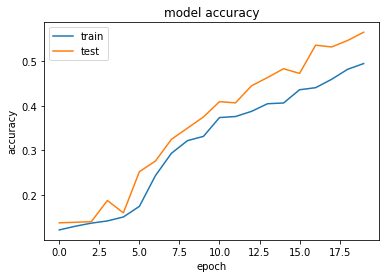

In [42]:
#plotting the model accuracy with the rise in epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
results = model_cnn_m.evaluate(X_val, y_val)
print('Val_acc using CNN with optimizer ADAM : ', results[1])

24/24 [==============================] - 1s 20ms/step - loss: 1.3863 - accuracy: 0.5645
Val_acc using CNN with optimizer ADAM :  0.5644736886024475


- Adding more layer has not helped to increase the accuracy and loss, rather it has decreased. In the next model, we will try with lesser layer and more number of neurons in fully connected dense layer
- this model is suffering from a little overfittling in coparison of previous models, as the gap between accuracy and val_accuracy has increased

# **More Neurons in fully connceted dense layer and reducing the number of hidden layers**

In [44]:
# initialized a sequential model
model_cnn_d = Sequential()

In [45]:
# adding first conv layer with 256 filters and kernel size 5x5 , with ReLU activation and padding 'same' provides the output size same as the input size
#input_shape denotes input image dimension of images
model_cnn_d.add(Conv2D(filters = 256, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))  # Shape of the image given to the model
# adding max pooling to reduce the size of output of first conv layer
model_cnn_d.add(MaxPooling2D(pool_size=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn_d.add(Dropout(0.25))

#  adding second conv layer with 128 filters and with kernel size 3x3 and ReLu activation function
model_cnn_d.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# adding max pooling havinf pool_size and strides with (2,2) to reduce the size of output of second conv layer
model_cnn_d.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn_d.add(Dropout(0.25))

#  adding third conv layer with 128 filters and with kernel size 3x3 and ReLu activation function
model_cnn_d.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# adding max pooling havinf pool_size and strides with (2,2) to reduce the size of output of third conv layer
model_cnn_d.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#  adding dropout to randomly switch off 25% neurons to reduce overfitting
model_cnn_d.add(Dropout(0.25))

# flattening the 3-d output of the conv layer after max pooling to make it ready for creating dense connections
model_cnn_d.add(Flatten())
# adding a fully connected dense layer with 256 neurons 
model_cnn_d.add(Dense(512, activation = "relu"))
model_cnn_d.add(Dropout(0.5))

# adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem.
model_cnn_d.add(Dense(12, activation = "softmax"))

In [50]:
model_cnn_d.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 256)     19456     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 64, 64, 256)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 32, 32, 128)      

- The number of parameter we will have in this model is 17,245,964

In [46]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model_cnn_d.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Fitting the model with 30 epochs and validation_split as 20%
history = model_cnn_d.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size = 200, epochs = 20, verbose = 1, callbacks=[es, mc])

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 2.4322 - accuracy: 0.1359
Epoch 1: val_accuracy improved from -inf to 0.23947, saving model to best_model.h5
16/16 [==============================] - 6s 347ms/step - loss: 2.4322 - accuracy: 0.1359 - val_loss: 2.4408 - val_accuracy: 0.2395
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 2.3909 - accuracy: 0.1720
Epoch 2: val_accuracy did not improve from 0.23947
16/16 [==============================] - 5s 303ms/step - loss: 2.3909 - accuracy: 0.1720 - val_loss: 2.3801 - val_accuracy: 0.1921
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 2.2541 - accuracy: 0.2385
Epoch 3: val_accuracy improved from 0.23947 to 0.33289, saving model to best_model.h5
16/16 [==============================] - 5s 332ms/step - loss: 2.2541 - accuracy: 0.2385 - val_loss: 2.1892 - val_accuracy: 0.3329
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 2.0347 - accuracy: 0.3174
Epoch 4: va

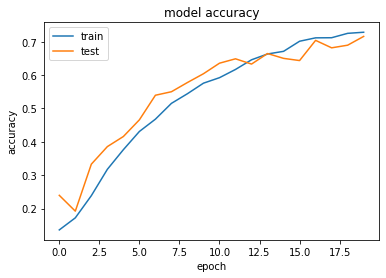

In [47]:
#plotting the model accuracy with the rise in epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
results = model_cnn_d.evaluate(X_val, y_val)
print('Val_acc using CNN with optimizer ADAM and more neurons in interactive layer : ', results[1])

24/24 [==============================] - 0s 20ms/step - loss: 0.8880 - accuracy: 0.7158
Val_acc using CNN with optimizer ADAM and more neurons in interactive layer :  0.7157894968986511


- With this model , we have more better performence in accuracy with 72 percent and loss, also the model is not suffering from overfitting. 
- So far this is the best performence of the model

- Adding more layers has not improved accuracy, rather it has decreased and also the loss has increased

# **Predicting Accuracy, Precision, f_beta score using different models on test data**

**Using the best model CNN_d**

In [52]:
# Test Prediction 
y_test_pred = model_cnn_d.predict(X_test)
y_test_pred_ln2 = np.argmax(y_test_pred, axis=1)
y_test_n = np.argmax(y_test, axis=1)

In [53]:
# Test Accuracy 
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score((y_test_n), y_test_pred_ln2)

0.6873684210526316

- The model has 69 percent of accuracy on the test data.

In [57]:
from sklearn.metrics import precision_recall_fscore_support  

p=precision_recall_fscore_support(y_test_n, y_test_pred_ln2, average=None,labels=list(np.unique(y_test_n)))

print(" Precision is {}\n Recall is {} \n f_beta Score is {}".format(p[0],p[1],p[2]))

 Precision is [0.57142857 0.89855072 0.89361702 0.68387097 0.6        0.71111111
 0.61139896 0.575      0.6440678  0.35294118 0.75652174 0.67532468]
 Recall is [0.1509434  0.79487179 0.72413793 0.86885246 0.20454545 0.67368421
 0.90076336 0.52272727 0.73786408 0.13043478 0.87878788 0.67532468] 
 f_beta Score is [0.23880597 0.84353741 0.8        0.76534296 0.30508475 0.69189189
 0.72839506 0.54761905 0.68778281 0.19047619 0.81308411 0.67532468]


- Test statstics on different labels on the test data.


**Tetsing the model on test data using cnn model**

In [74]:
#Test Prediction
y_test_pred1 = model_cnn.predict(X_test)
y_test_pred_ln1 = np.argmax(y_test_pred1, axis=1)
y_test_n1 = np.argmax(y_test, axis=1)

In [75]:
# Test Accuracy 
accuracy_score((y_test_n1), y_test_pred_ln1)

0.6505263157894737

- Accuracy score using this model: 65 percent

In [81]:
p=precision_recall_fscore_support(y_test_n1, y_test_pred_ln1, average=None,labels=list(np.unique(y_test_n1)))

print(" Precision is {}\n Recall is {} \n f_beta Score is {}".format(p[0],p[1],p[2], p[3]))

 Precision is [0.28301887 0.66666667 0.7804878  0.75373134 0.55882353 0.64285714
 0.69158879 0.62790698 0.60169492 0.51724138 0.78761062 0.56790123]
 Recall is [0.28301887 0.84615385 0.55172414 0.82786885 0.43181818 0.66315789
 0.5648855  0.61363636 0.68932039 0.32608696 0.8989899  0.5974026 ] 
 f_beta Score is [0.28301887 0.74576271 0.64646465 0.7890625  0.48717949 0.65284974
 0.62184874 0.62068966 0.64253394 0.4        0.83962264 0.58227848]


Test prediction using model CNN_m

In [82]:
#Test Prediction
y_test_pred3 = model_cnn_m.predict(X_test)
y_test_pred_ln3 = np.argmax(y_test_pred3, axis=1)
y_test_n3 = np.argmax(y_test, axis=1)

In [83]:
# Test Accuracy 
accuracy_score((y_test_n3), y_test_pred_ln3)

0.5463157894736842

In [84]:
p=precision_recall_fscore_support(y_test_n3, y_test_pred_ln3, average=None,labels=list(np.unique(y_test_n3)))

print(" Precision is {}\n Recall is {} \n f_beta Score is {}".format(p[0],p[1],p[2], p[3]))

 Precision is [0.45454545 0.71641791 0.90909091 0.59090909 0.         0.45833333
 0.52863436 0.43181818 0.42748092 0.27272727 0.64492754 0.56756757]
 Recall is [0.09433962 0.61538462 0.17241379 0.85245902 0.         0.46315789
 0.91603053 0.43181818 0.54368932 0.06521739 0.8989899  0.27272727] 
 f_beta Score is [0.15625    0.66206897 0.28985507 0.69798658 0.         0.46073298
 0.67039106 0.43181818 0.47863248 0.10526316 0.75105485 0.36842105]


Overall the best performance generated by the model CNN_d

# **Conclusion**

- The datas consist of 12 plant siedlings
- the major objective was to predict the label, to identify the images
- We have different models with ANN, CNN have used. here also SGD optimizer with ADAM has used. However in most of the model adam was used
- Also in this project dropout, maxpooling layers were used
- The model with cnn, with adam optimizer with learning rate has shown the best performence on validation data 72 percent  and this mode on test data has shown the accuracy level of 68 percent